In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

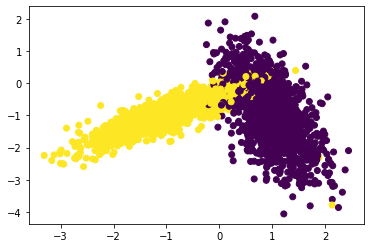

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [20]:
def RandomSearchCV(X_train,Y_train,neighbour,param_range,folds):
    param_range = list(param_range)
    # to generate 10 unique values(int-datatype) randomly following Uniform distrubution
    params = sorted(list(random.sample(range(param_range[0],param_range[1]+1), 10)))
    train_scores = []
    test_scores = []
    for k in tqdm(params):
        length = int(len(X_train)/folds) # length of each chunk/fold
        x_train = []
        y_train = []        
        # splitting data into chunks based on the folds provided
        for i in range(0,len(X_train),length):
            x_train.append(X_train[i:i+length])               
            y_train.append(Y_train[i:i+length])   
        
        test_scores_folds = []
        train_scores_folds = []
        
        # forming train and test data sets
        for i in range(0,folds): 
            s = {i}
            x_testing_data = x_train[i]# keeping test data and moving the remaining to train data
            y_testing_data = y_train[i]# corresponding class labels for the test data
            x_training_data = []
            y_training_data = []
            training_idx = list(set(range(0,len(x_train))) - s)# removing the testing dataset and storing train data
            for j in training_idx:
                x_training_data+=list(x_train[j])
                y_training_data+=list(y_train[j])
            
            # measuring accuracy scores from train and test data for all combinations in the given number of folds
            neighbour.n_neighbors = k
            neighbour.fit(x_training_data,y_training_data)
            
            y_predicted = neighbour.predict(x_testing_data)
            test_scores_folds.append(accuracy_score(y_testing_data, y_predicted))
            
            y_predicted = neighbour.predict(x_training_data)
            train_scores_folds.append(accuracy_score(y_training_data, y_predicted))
            
        # Train and test accuracy scores for each k value
        train_scores.append(np.mean(np.array(train_scores_folds))) 
        test_scores.append(np.mean(np.array(test_scores_folds)))
    return train_scores,test_scores,params       

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

[4, 6, 20, 25, 30, 32, 35, 40, 41, 42]


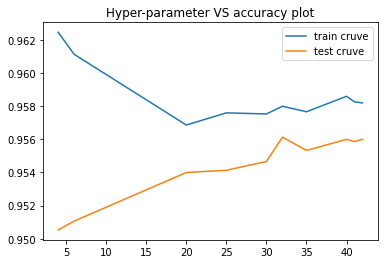

In [21]:
# Necessary imports
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
import random
warnings.filterwarnings("ignore")

neighbour = KNeighborsClassifier() # initialising KNN classifier 
param_range = (1,50) # To select 10 values from the given parameter range
folds = 3 # No.of folds to be used for measuring the accuracy score

# will be useful to plot hyper parameter tuning graph
train_score,cv_scores,params = RandomSearchCV(X_train,y_train,neighbour,param_range,folds)

print(params)
plt.plot(params,train_score, label='train cruve')
plt.plot(params,cv_scores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [22]:
def plot_decision_boundary(X1, X2, y, clf):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

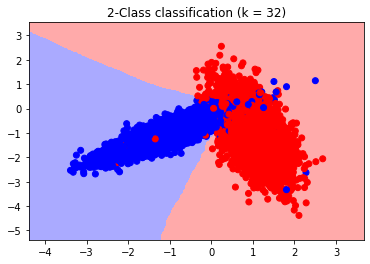

In [26]:
from matplotlib.colors import ListedColormap
# k = 32 is chosen as its having sweet spot between train and CV curve 
neighbour = KNeighborsClassifier(n_neighbors = 32)
neighbour.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neighbour)